# SARIMA Model


- produce reliable forecasts of a given time series by applying one of the most commonly used method for time series forecasting: ARIMA

In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

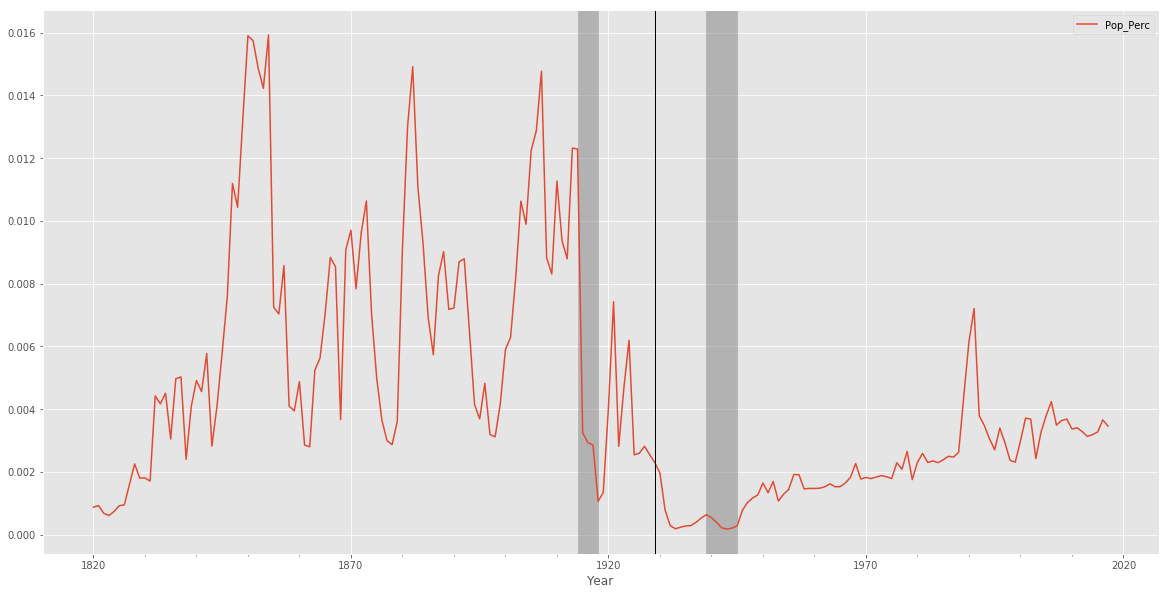

In [4]:
imm = pd.read_excel('Data/Total_immigration_by_year.xlsx') 
imm.set_index('Year', inplace = True) #set index as year
imm.index= imm.index.astype(str) #change to str for date time format
imm.index = pd.to_datetime(imm.index)
by_year_df = pd.read_csv('pop_all.csv')
by_year_df.index= imm.index
total_immigration = by_year_df['Pop_Perc'].to_frame()
total_immigration.plot(figsize = (20,10))
plt.axvline(pd.to_datetime('1929-10-29'), color='black', linestyle='-', lw=1)

plt.axvspan(pd.to_datetime('1939-09-01'), pd.to_datetime('1945-09-01'), alpha=0.5, color='grey')
plt.axvspan(pd.to_datetime('1914-07-28'), pd.to_datetime('1918-11-11'), alpha=0.5, color='grey')

### Number of AR (Auto-Regressive) terms (p): 

`p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Number of Differences (d):

`d` is the **Integrated** component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last *n* days is small. 

### Number of MA (Moving Average) terms (q): 

`q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [HERE](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

## Parameter Selection


The first step towards fitting an ARIMA model is to find the values of `ARIMA(p,d,q)(P,D,Q)s` that produce the desired output. Selection of these parameters requires domain expertise and time.  We shall first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the statsmodels module and assess its overall quality. 

`SARIMAX` detailed documentation can be viewed [HERE](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

Let's begin by generating example combination of parameters that we wish to use.

1. Define p,q and d parameters to take any value from 0/1 using `range()` function. (Note: We can try larger values which can make our model computationally expensive to run, you can try this as an additional experiment)

2. Generate combinations for `(p,d,q)` using `itertools.product`.
3. Similarly, generate seasonal combinations as `(p,d,q)s`. Use s = 12 (constant)
4. Check the combinations for validity.

In [5]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


## AIC (Akaike Information Criterion) 

For evaluating the model, we shall use the AIC (Akaike Information Criterion) value, which is provided by ARIMA models fitted using `statsmodels` library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

1. Initialize an empty list to store results
2. iterate through all the paramaters in pdq with parameters in seasonal pdq (nested loop ) to create a grid
3. Run `SARIMAX` from statsmodels for each iteration. Details can be found [HERE](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). Set `enforce_stationarity` and `enforce_invertibility` to False. 
4. Get the results in each iteration with `model.fit()` and store the AIC values. 
5. Find the lowest AIC and select parameters for further analysis. 

NOTE: 
* Integrate exception handling with `continue`. 
* An overview of Akaike Information Criterion can be viewed [HERE](http://www.statisticshowto.com/akaikes-information-criterion/)



In [6]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(total_immigration,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

            
            
# ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.34362403487
# ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727637512
# ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320024
#     .
#     .
#     .
#     .
# ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:327.9049164493077
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:444.1243686483202
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.78021965631604    

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =-1465.5013378583128
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =-1433.7774011772663
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-1467.2306270008826
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-1408.9206764815517
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-1501.1407258673814


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-1529.389069764367
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-1404.6847077180691


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-1424.0867929208955
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =-1674.3181178893478


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =-1610.3181838062042
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-1595.2838671000663


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-1538.4414503213027
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-1649.1609178576775


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1656.3671584002288


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =-1538.3123462861065


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =-1528.5153606780577
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =-1919.887465822516
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =-1794.66450529321
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =-1639.809551820158
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =-1650.3365554153127
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =-1805.7164961948574
ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =-1793.0363865387467


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =-1593.10424446812
ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =-1633.1531514321584
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =-1907.0487716850082
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =-1781.882379322055


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =-1627.828434845554
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =-1634.109615389625
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =-1803.640449916284
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1780.313820066261


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =-1590.3917645385666


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =-1620.8562046964198
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =-1933.2372733899024
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =-1789.1419338594897
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-1666.0974837233284


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-1624.5848411282018
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-1743.6962810054433


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-1786.2340476284226
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-1601.1810024931083


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-1611.2209730063937
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =-1920.4127410938668
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =-1776.4354636715364
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-1657.6792360011175


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-1615.3776552711731


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-1741.908104112538


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1774.0170611360936
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =-1600.7833661474792


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =-1601.2013896062585
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =-1918.039618768954
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =-1792.9663171828154
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =-1637.8305250732333


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =-1644.2430316154737
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =-1793.2153541336172
ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =-1791.3781052025683
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =-1581.343362873764


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =-1631.1143739795452
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =-1905.0514926149542


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =-1779.857066313358
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =-1630.8340438570372


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =-1635.7680247345907


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =-1790.768437259825
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1778.2031874199304


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =-1582.950279115234
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =-1622.3141368648153


In [7]:
# Find the parameters with minimal AIC value.

ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

# pdq         (1, 1, 1)
# pdqs    (1, 1, 1, 12)
# aic            277.78
# Name: 59, dtype: object

pdq         (1, 0, 0)
pdqs    (0, 0, 0, 12)
aic          -1933.24
Name: 32, dtype: object

The output of our code suggests that `ARIMA(1, 1, 1)x(1, 1, 1, 12)` yields the lowest AIC value of `277.78`. We should therefore consider this to be optimal option out of all the models we have considered.

## Model Fitting

In the simple grid example above, we identified the set of parameters that produced the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

Let's plug in the optimal parameter values into a new SARIMAX model:

In [8]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(total_immigration,
                                order=(1, 0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

# ==============================================================================
#                  coef    std err          z      P>|z|      [0.025      0.975]
# ------------------------------------------------------------------------------
# ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
# ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
# ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
# ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
# sigma2         0.0972      0.004     22.632      0.000       0.089       0.106
# ==============================================================================

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9536      0.015     62.812      0.000       0.924       0.983
sigma2      3.139e-06   1.99e-07     15.786      0.000    2.75e-06    3.53e-06


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The model returns a lot of information, but we'll focus only on the table of coefficients. The `coef` column above shows the importance of each feature and how each one impacts the time series patterns.  The **P>|z|** provides  the significance of each feature weight. 

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated. 

The `plot_diagnostics()` function on ARIMA output below:

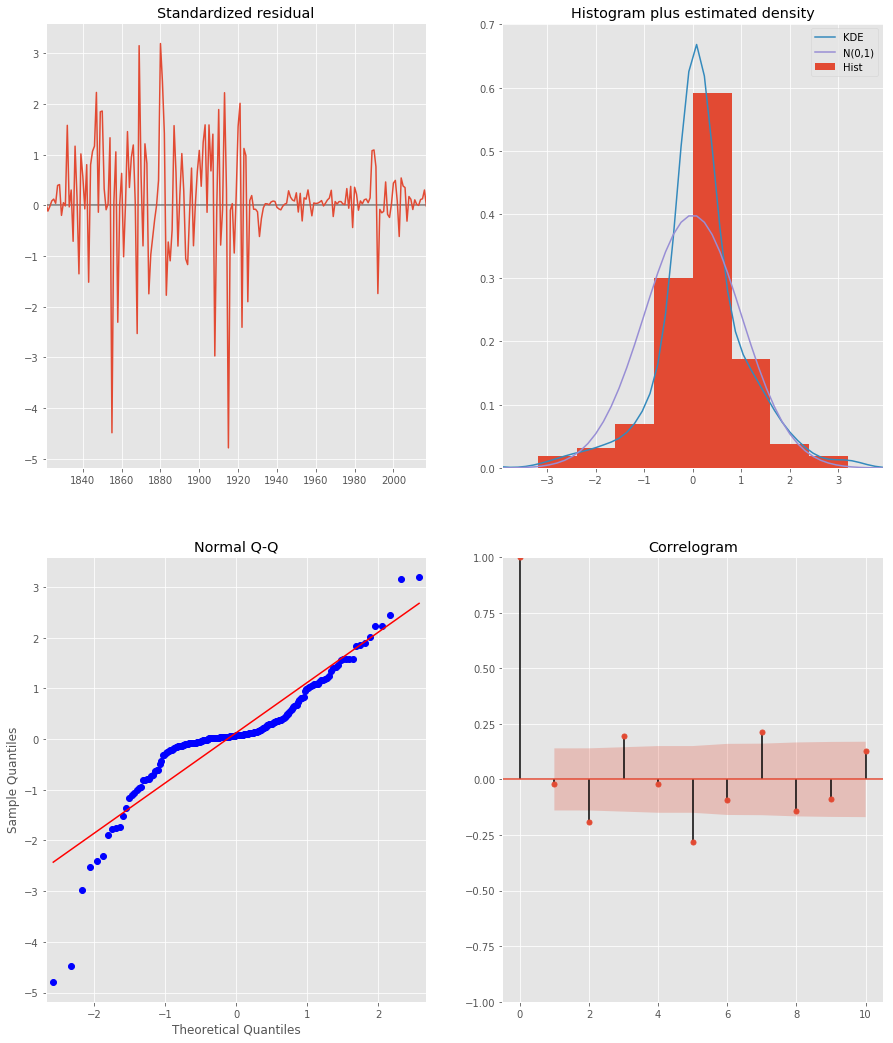

In [9]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The purpose here to ensure that residuals remain un-correlated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweating of the model. 

Let's check for these assumptions from diagnostics plots.

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces has no correlations and provides a satisfactory fit to help forecast future values.


## Validating the Model

### One-step Ahead Forecasting

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. 

The `get_prediction()` and `conf_int()` attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.


[Documentation of `get_predictions()`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_prediction.html)

[Documentation for `conf_int()`](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMAResults.conf_int.html)

* Get the predictions from 1st January 1998 till 2002 ( end of time-series)

* Get the confidence intervals for all predictions.

* For `get_predictions()`, set the `dynamic` parameter to False to ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.



In [12]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_conf = pred.conf_int()

We shall now plot the real and forecasted values of the CO2 time series to assess how well we did. 

* Plot the observed values from the dataset, starting at 1990.
* Use `predicted_mean.plot()` with `prediction` to plot predictions.
* Plot the confidence intervals overlapping the predicted values.


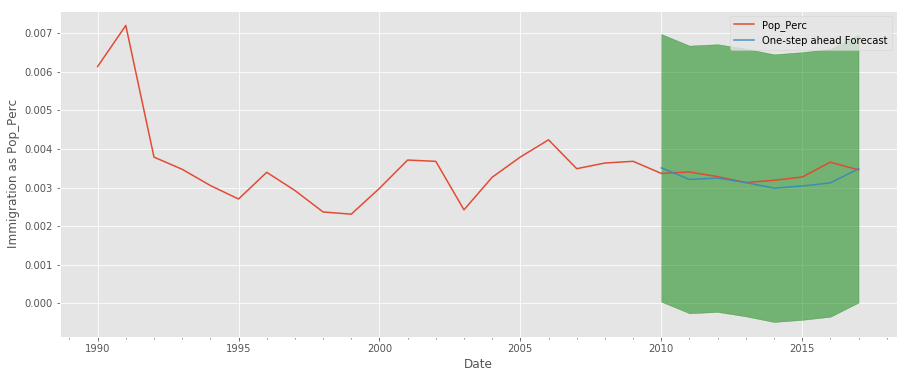

In [13]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = total_immigration['1990':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Immigration as Pop_Perc')
plt.legend()

plt.show()

The forecasts align with the true values  as seen above,with overall increase trend. We shall also check for the accuracy of our forecasts using  **MSE (Mean Squared Error)**. This will provide us with the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [14]:
# Get the Real and predicted values
total_immigration_forecasted = pred.predicted_mean
total_immigration_truth = total_immigration['2010-01-01':]

# Compute the mean square error
mse = ((total_immigration_forecasted - total_immigration_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 0.07

The Mean Squared Error of our forecasts is 2010-01-01 00:00:00   NaN
2011-01-01 00:00:00   NaN
2012-01-01 00:00:00   NaN
2013-01-01 00:00:00   NaN
2014-01-01 00:00:00   NaN
2015-01-01 00:00:00   NaN
2016-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
Pop_Perc              NaN
dtype: float64


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

### Dynamic Forecasting

We can achieve a deeper insight into model's predictive power using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

Repeat above calculation for predictions post 1998. Use Dynamic forecasting by setting `dynamic` to True.

In [15]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.



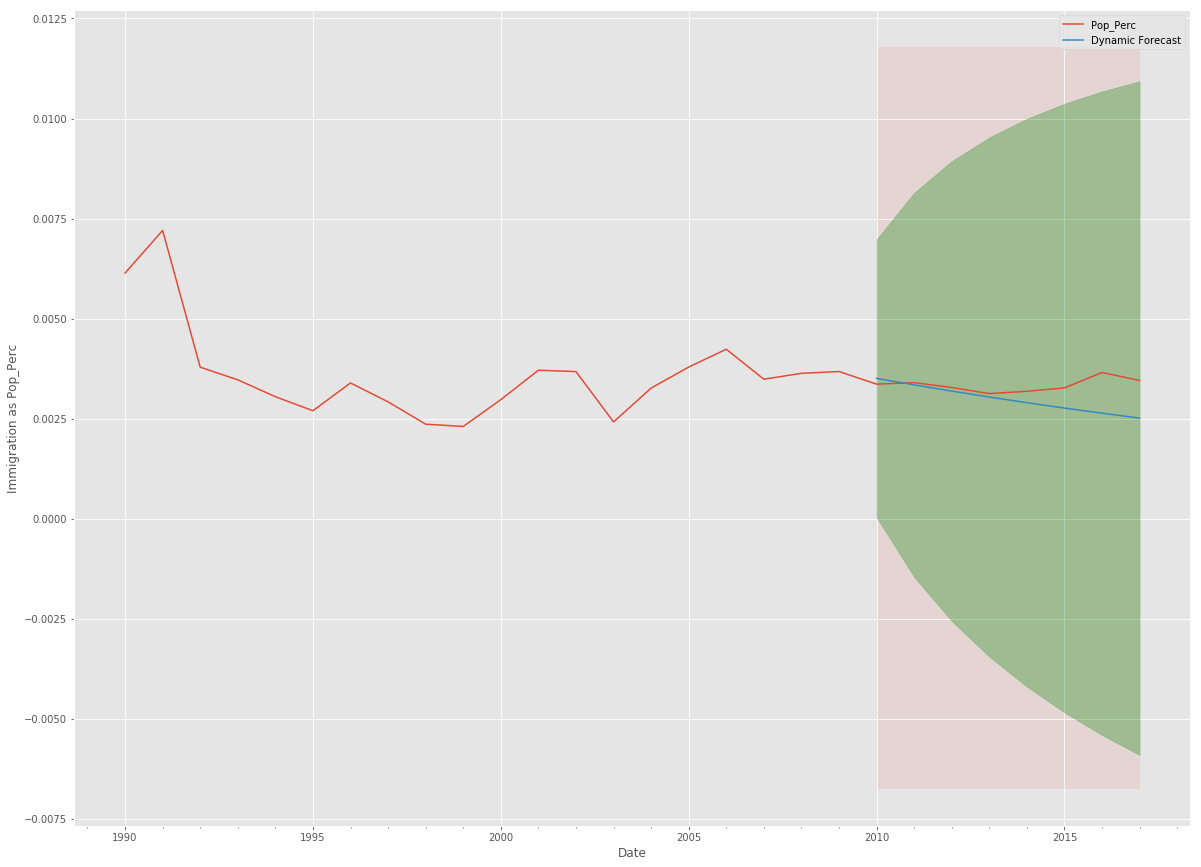

In [17]:
# Plot the dynamic forecast with confidence intervals.

ax = total_immigration['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2010-01-01'), total_immigration_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Immigration as Pop_Perc')

plt.legend()
plt.show()

Once again, we quantify the predictive performance of our forecasts by computing the MSE.

In [18]:
# Extract the predicted and true values of our time series
total_immigration_forecasted = pred_dynamic.predicted_mean
total_immigration_truth = total_immigration['2010-01-01':]

# Compute the mean square error
mse = ((total_immigration_forecasted - total_immigration_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# The Mean Squared Error of our forecasts is 1.01

The Mean Squared Error of our forecasts is 2010-01-01 00:00:00   NaN
2011-01-01 00:00:00   NaN
2012-01-01 00:00:00   NaN
2013-01-01 00:00:00   NaN
2014-01-01 00:00:00   NaN
2015-01-01 00:00:00   NaN
2016-01-01 00:00:00   NaN
2017-01-01 00:00:00   NaN
Pop_Perc              NaN
dtype: float64


The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.



## Producing and Visualizing Forecasts

We will now describe how to leverage our seasonal ARIMA time series model to forecast future values. The `get_forecast()` attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [19]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 2263-01-01 00:00:00

We can use the output of this code to plot the time series and forecasts of its future values.



NameError: name 'prediction' is not defined

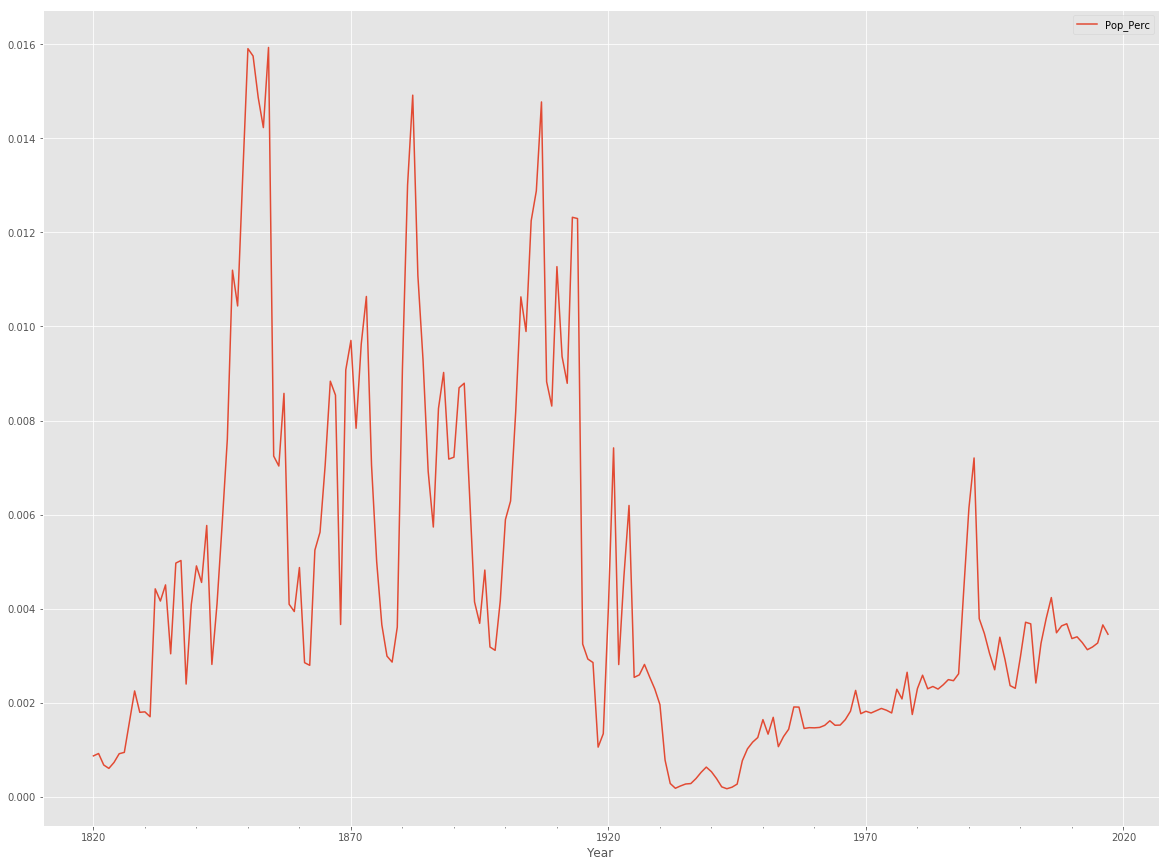

In [21]:
# Plot future predictions with confidence intervals

ax = total_immigration.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.



## Bonus Exercises

* Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
* Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.
* Select a different metric to select the best model. For example, we used the AIC measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead.

## Summary

In this lab, we described how to implement a seasonal ARIMA model in Python. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the CO2 time series.